In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import pandas as pd

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True
)


Found 2152 files belonging to 3 classes.


In [16]:
from tensorflow.keras.applications import EfficientNetB0
feature_extractor = EfficientNetB0(include_top=False, pooling='avg', input_shape=(256, 256, 3))
feature_extractor.trainable = False

def extract_features(dataset, batch_size=8):  # ↓ smaller batch size
    features = []
    labels = []

    for batch_images, batch_labels in dataset:
        # Resize + Normalize
        batch_images = tf.image.resize(batch_images, (256, 256))
        batch_images = batch_images / 255.0

        # Manually split into sub-batches to reduce memory
        num_samples = batch_images.shape[0]
        for i in range(0, num_samples, batch_size):
            sub_batch = batch_images[i:i + batch_size]
            sub_features = feature_extractor.predict(sub_batch, verbose=0)
            features.append(sub_features)

        labels.append(batch_labels.numpy())

    return np.vstack(features), np.concatenate(labels)


In [4]:
class_names = dataset.class_names
num_classes = len(class_names)

In [5]:
class_names 

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
num_classes

3

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(image_batch[0].shape)

(32, 256, 256, 3)
(256, 256, 3)


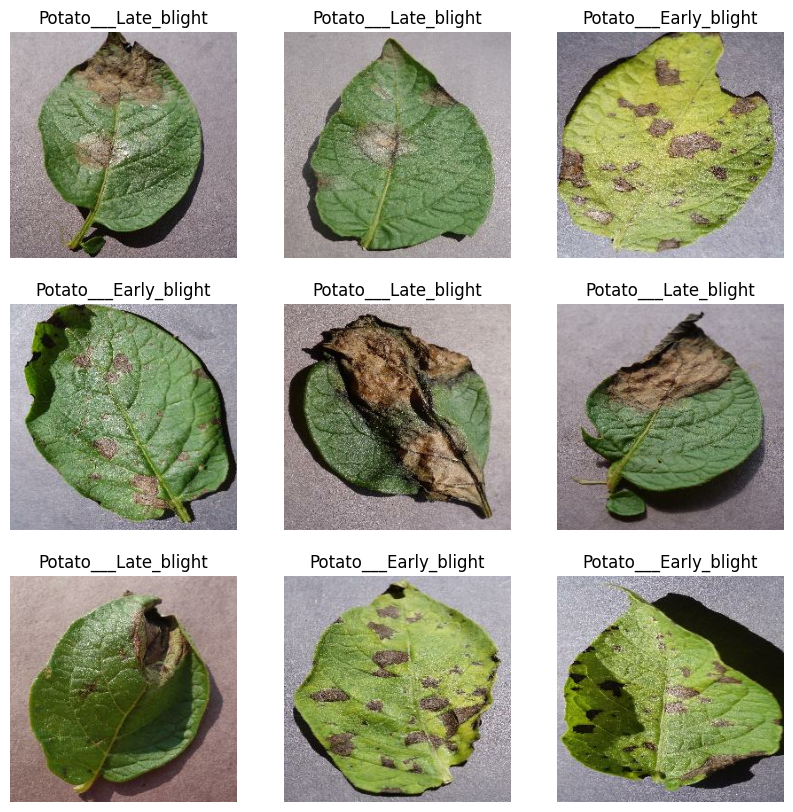

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [9]:
# 80% ==> training
# 20% ==> 10% validation, 10% testing

In [10]:
train_size = (0.8 * len(dataset))
train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size = (0.1 * len(dataset))
val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [17]:
X_train, y_train = extract_features(train_ds, batch_size=4)
X_val, y_val = extract_features(val_ds, batch_size=4)
X_test, y_test = extract_features(test_ds, batch_size=4)

In [21]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [27]:
# Predict on validation and test sets
val_preds = model.predict(X_val)
test_preds = model.predict(X_test)


# Validation performance
val_report = classification_report(y_val, val_preds, target_names=dataset.class_names, output_dict=True)
test_report = classification_report(y_test, test_preds, target_names=dataset.class_names, output_dict=True)

# Convert to DataFrames
val_df = pd.DataFrame(val_report).transpose()
test_df = pd.DataFrame(test_report).transpose()

# Display nicely formatted tables
print("📊 Validation Classification Report:")
display(val_df.round(2))  # If in Jupyter, or just use print(val_df.round(2))

print("\n📊 Test Classification Report:")
display(test_df.round(2))

📊 Validation Classification Report:


precision  recall  f1-score  support
Potato___Early_blight       0.97    0.97      0.97    97.00
Potato___Late_blight        0.91    0.98      0.94    80.00
Potato___healthy            0.89    0.53      0.67    15.00
accuracy                    0.94    0.94      0.94     0.94
macro avg                   0.92    0.83      0.86   192.00
weighted avg                0.94    0.94      0.93   192.00


📊 Test Classification Report:


precision  recall  f1-score  support
Potato___Early_blight       0.97    0.96      0.96   117.00
Potato___Late_blight        0.92    0.99      0.95   102.00
Potato___healthy            1.00    0.46      0.63    13.00
accuracy                    0.94    0.94      0.94     0.94
macro avg                   0.96    0.80      0.85   232.00
weighted avg                0.95    0.94      0.94   232.00

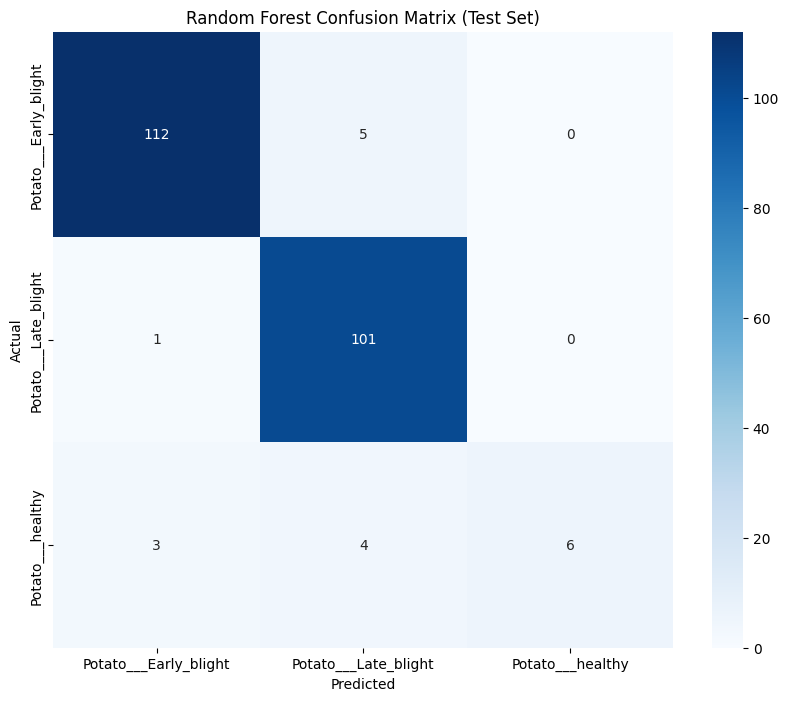

In [26]:
# Confusion Matrix on Test Data
cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix (Test Set)")
plt.show()

In [29]:
from sklearn.metrics import accuracy_score

train_preds = model.predict(X_train)
val_preds = model.predict(X_val)
test_preds = model.predict(X_test)

train_acc = accuracy_score(y_train, train_preds)
val_acc = accuracy_score(y_val, val_preds)
test_acc = accuracy_score(y_test, test_preds)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Train Accuracy: 1.0000
Validation Accuracy: 0.9375
Test Accuracy: 0.9440


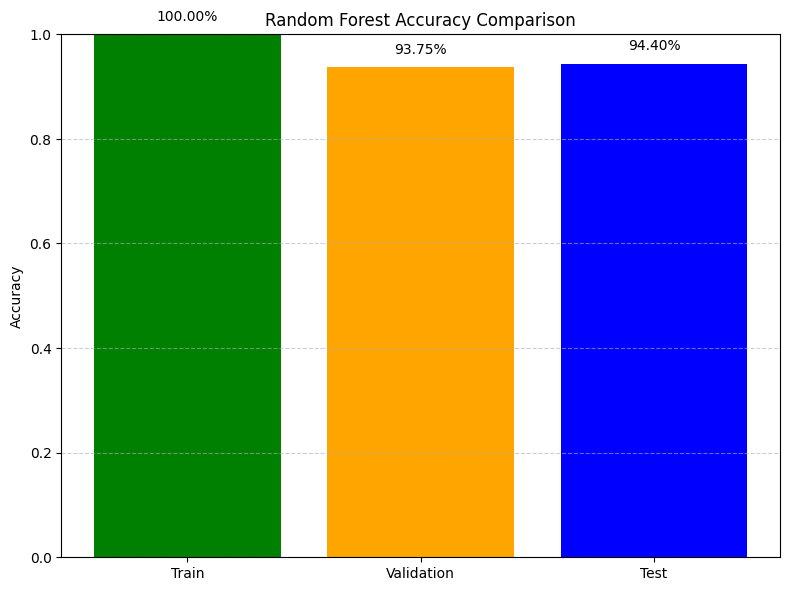

In [30]:
plt.figure(figsize=(8, 6))
plt.bar(['Train', 'Validation', 'Test'], [train_acc, val_acc, test_acc], color=['green', 'orange', 'blue'])
plt.ylim(0, 1.0)
plt.title('Random Forest Accuracy Comparison')
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Display accuracy values on bars
for i, acc in enumerate([train_acc, val_acc, test_acc]):
    plt.text(i, acc + 0.02, f"{acc:.2%}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [34]:
from PIL import Image
from tensorflow.keras.preprocessing import image
import numpy as np

def predict(model, image_array, class_names):
    """
    Predict the class and confidence using a trained ML model and a single image (as array).
    Expects image_array shape: (256, 256, 3)
    """
    # Preprocess: normalize and batch
    img = image_array / 255.0
    img = np.expand_dims(img, axis=0)  # shape: (1, 256, 256, 3)

    # Extract features using CNN
    features = feature_extractor.predict(img, verbose=0)

    # Predict using ML model
    proba = model.predict_proba(features)[0]
    predicted_index = np.argmax(proba)
    predicted_class = class_names[predicted_index]
    confidence = round(100 * proba[predicted_index], 2)

    return predicted_class, confidence

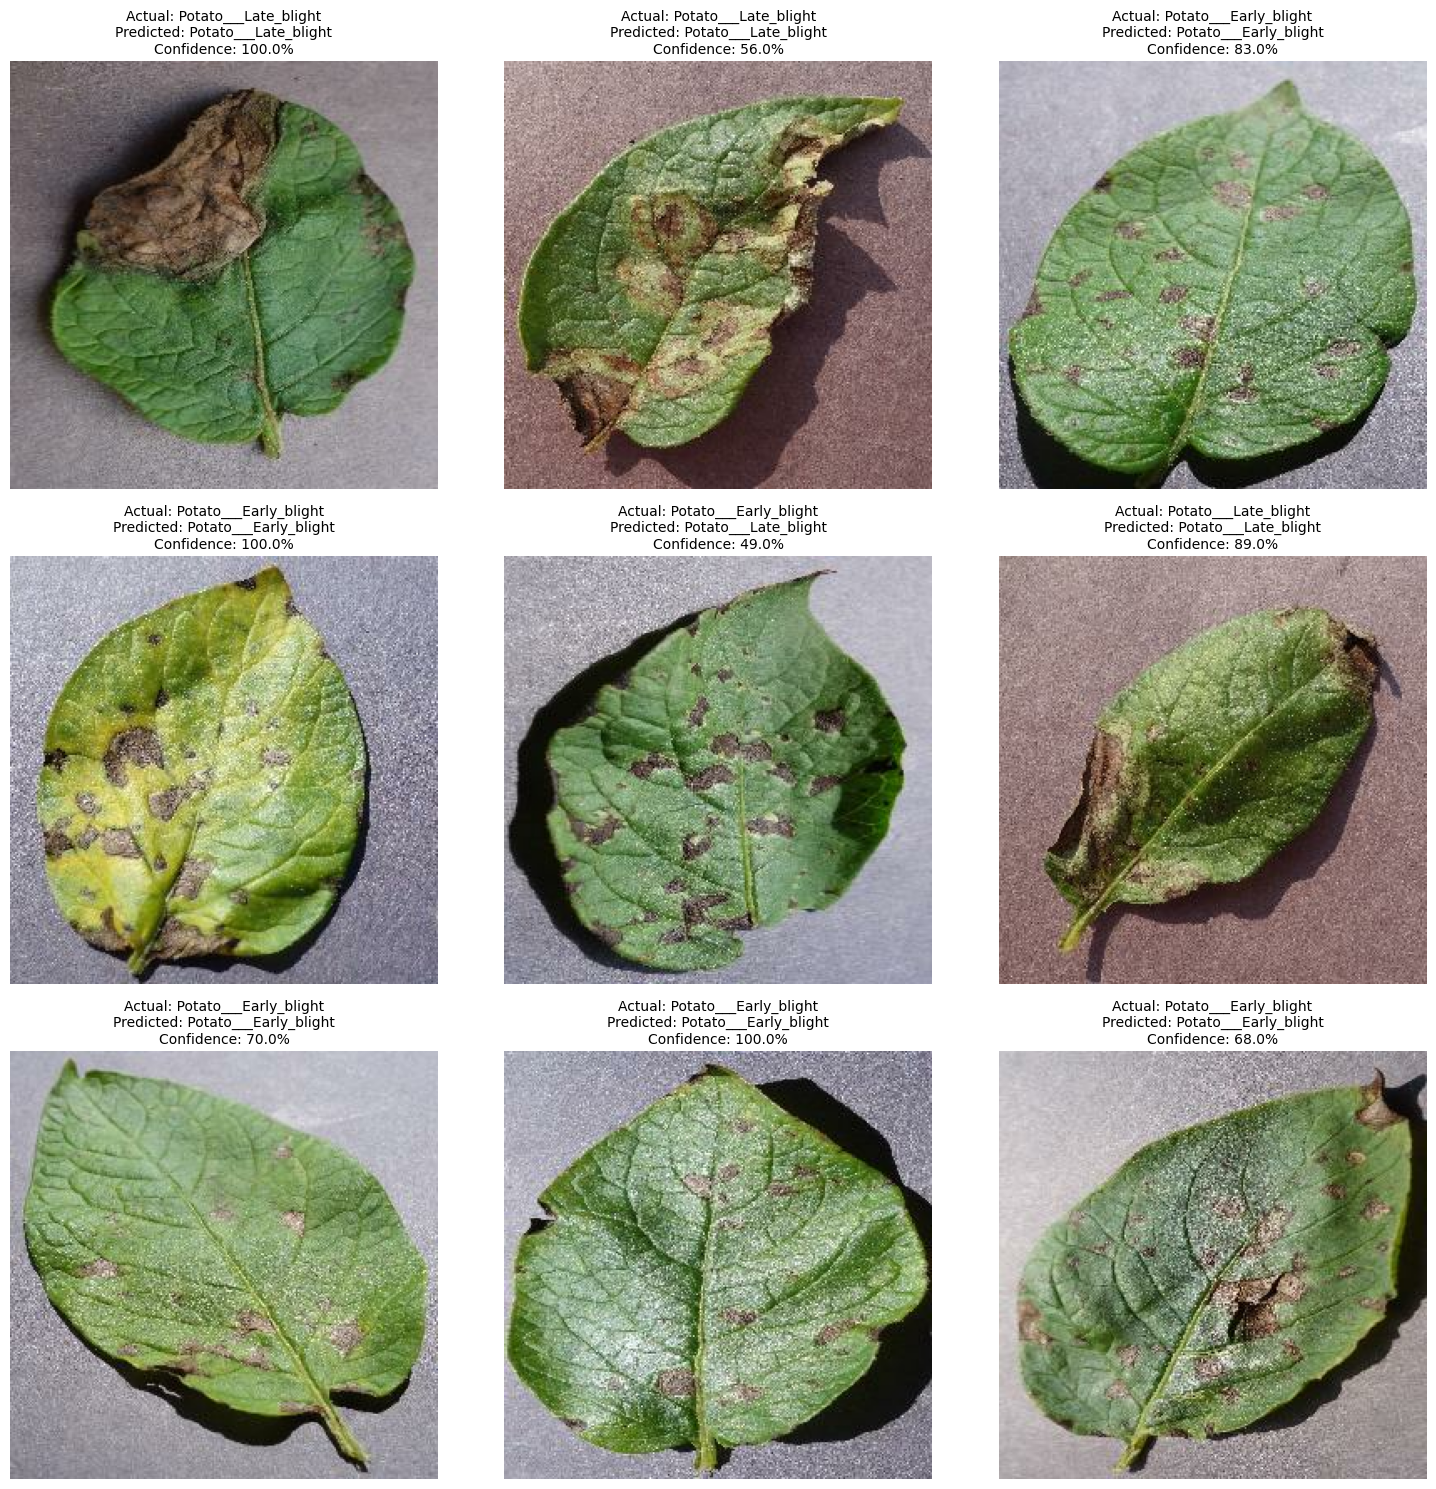

In [35]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        # Get predicted class and confidence
        predicted_class, confidence = predict(model, images[i], class_names)
        actual_class = class_names[labels[i].numpy()]

        # Display image and prediction
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%", fontsize=10)
        plt.axis("off")

plt.tight_layout()
plt.show()


In [38]:
import joblib

joblib.dump(model, "../models/rf_model.pkl") 

['../models/rf_model.pkl']